In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import model_20250901
import simulate
from sklearn.metrics import r2_score
import importlib


In [17]:
device = "cpu"
random_seed = 2025
r2 = 0.5
n = 1000
dim = 112
coord, true_beta, img_data, y = simulate.simulate_data(n, r2, dim, random_seed)

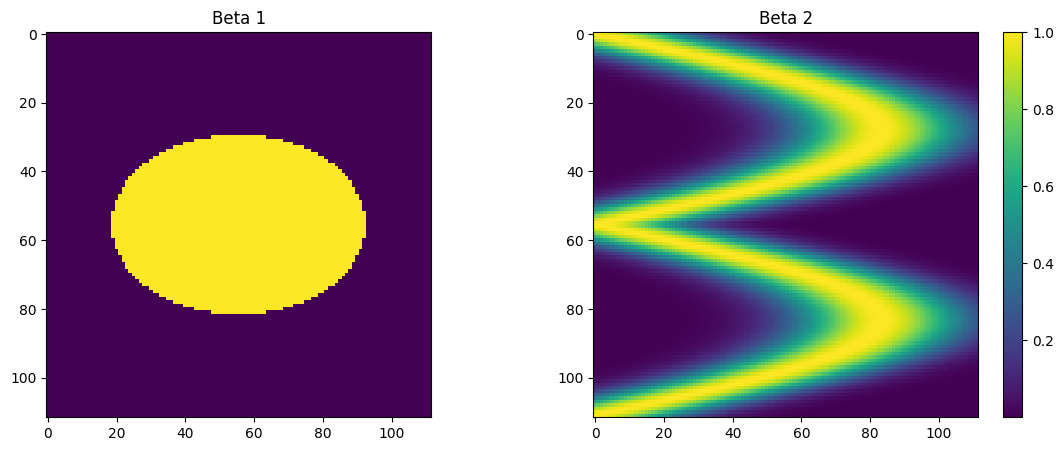

In [18]:
fig, axs = plt.subplots(1, 2, figsize = (14,5))
axs[0].imshow(true_beta[0].reshape(dim, dim))
axs[0].set_title("Beta 1")

cax = axs[1].imshow(true_beta[1].reshape(dim, dim))
axs[1].set_title("Beta 2")

fig.colorbar(cax, ax = axs[1])
plt.show()



In [19]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

image_data_0_reshaped = img_data[0].reshape(n, dim, dim)
image_data_1_reshaped = img_data[1].reshape(n, dim, dim)

stacked_img = np.concatenate([image_data_0_reshaped, image_data_1_reshaped], axis = 1)
stacked_img = stacked_img[:, np.newaxis, :, :]

y = y.reshape(-1, 1)
y_tensor = torch.tensor(y, dtype = torch.float32).to(device)
stacked_img_tensor = torch.tensor(stacked_img, dtype = torch.float32).to(device)

torch.manual_seed(random_seed)
np.random.seed(random_seed)

X_train, X_test, y_train, y_test = train_test_split(stacked_img_tensor, y_tensor, test_size = 0.2, random_state = random_seed)
train_dataset = TensorDataset(X_train, y_train)
test_dataset =  TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle = False)

In [20]:
def train_cnn_model(model_class=model_20250901.CNN_3_3_16_512, 
                    lr=0.001, 
                    weight_decay=0.0, 
                    num_epochs=50, 
                    train_loader=None, 
                    test_loader=None, 
                    device='cuda' if torch.cuda.is_available() else 'cpu',
                    verbose=True,
                    plot_results=True):
    """
    Train a CNN model with customizable parameters and track performance metrics.
    
    Args:
        model_class: CNN model class (default: CNN_3_3_16_512)
        lr: Learning rate (default: 0.001)
        weight_decay: L2 regularization (default: 0.0)
        num_epochs: Number of training epochs (default: 50)
        train_loader: Training data loader
        test_loader: Test/validation data loader
        device: Device to run training on
        verbose: Whether to print training progress
        plot_results: Whether to plot learning curves
    
    Returns:
        Dictionary containing training history and best metrics
    """
    # Initialize model, criterion and optimizer
    cnn = model_class().to(device)
    criterion = torch.nn.MSELoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr, weight_decay=weight_decay)

    # Initialize lists to track metrics
    train_losses = []
    test_losses = []
    all_train_r2 = []
    all_test_r2 = []
    
    best_epoch = 0
    best_test_loss = float('inf')
    best_test_r2 = -float('inf')

    for epoch in range(num_epochs):
        # --- Training Phase ---
        cnn.train()
        running_loss = 0.0
        y_pred, y_true = [], []
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_hat_batch = cnn(X_batch)
            loss = criterion(y_hat_batch, y_batch)
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                running_loss += loss.item()
                y_pred.extend(y_hat_batch.detach().cpu().numpy().flatten())
                y_true.extend(y_batch.cpu().numpy().flatten())
        
        # Calculate training metrics
        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)
        train_r2 = r2_score(y_true, y_pred)
        all_train_r2.append(train_r2)
        
        # --- Validation/Test Phase ---
        cnn.eval()
        with torch.no_grad():
            test_pred, test_true = [], []
            test_running_loss = 0.0
            
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_hat_batch = cnn(X_batch)
                loss = criterion(y_hat_batch, y_batch)
                test_running_loss += loss.item()
                test_pred.extend(y_hat_batch.detach().cpu().numpy().flatten())
                test_true.extend(y_batch.cpu().numpy().flatten())
            
            epoch_test_loss = test_running_loss / len(test_loader)
            test_losses.append(epoch_test_loss)
            test_r2 = r2_score(test_true, test_pred)
            all_test_r2.append(test_r2)
            
            # Update best epoch
            if epoch_test_loss < best_test_loss:
                best_test_loss = epoch_test_loss
                best_test_r2 = test_r2
                best_epoch = epoch + 1
        
        # Print metrics if verbose
        # if verbose and (epoch + 1) % 1 == 0:
        #     print(f"Epoch {epoch + 1}/{num_epochs}")
        #     print(f"  Train Loss: {epoch_train_loss:.4f} ± {np.std(train_losses):.4f}")
        #     print(f"  Train R²: {train_r2:.4f} ± {np.std(all_train_r2):.4f}")
        #     print(f"  Test Loss: {epoch_test_loss:.4f} ± {np.std(test_losses):.4f}")
        #     print(f"  Test R²: {test_r2:.4f} ± {np.std(all_test_r2):.4f}\n")

    # Final summary
    if verbose:
        print(f"\n=== {model_class.__name__} Training Summary ===")
        print(f"Best Epoch: {best_epoch}")
        print(f"Best Test Loss: {best_test_loss:.4f}")
        print(f"Corresponding Test R²: {best_test_r2:.4f}")
        print(f"Final Train Loss: {train_losses[-1]:.4f} ± {np.std(train_losses):.4f}")
        print(f"Final Train R²: {all_train_r2[-1]:.4f} ± {np.std(all_train_r2):.4f}")
        print(f"Final Test Loss: {test_losses[-1]:.4f} ± {np.std(test_losses):.4f}")
        print(f"Final Test R²: {all_test_r2[-1]:.4f} ± {np.std(all_test_r2):.4f}")

    # Plot results if requested
    if plot_results:
        plt.figure(figsize=(12, 5))

        # Plot Losses
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('MSE Loss')
        plt.title(f'{model_class.__name__} Training & Test Loss')
        plt.legend()

        # Plot R² Scores
        plt.subplot(1, 2, 2)
        plt.plot(all_train_r2, label='Train R²')
        plt.plot(all_test_r2, label='Test R²')
        plt.xlabel('Epoch')
        plt.ylabel('R² Score')
        plt.title(f'{model_class.__name__} R² Scores')
        plt.legend()

        plt.tight_layout()
        plt.show()

    return {
        'model': cnn,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_r2_scores': all_train_r2,
        'test_r2_scores': all_test_r2,
        'best_epoch': best_epoch,
        'best_test_loss': best_test_loss,
        'best_test_r2': best_test_r2,
        'final_train_loss': train_losses[-1],
        'final_test_loss': test_losses[-1],
        'final_train_r2': all_train_r2[-1],
        'final_test_r2': all_test_r2[-1]
    }

# Example usage:
# results = train_cnn_model(model_class=model.CNN2d512,
#                         lr=0.0001,
#                         weight_decay=0.01,
#                         num_epochs=100,
#                         train_loader=train_loader,
#                         test_loader=test_loader)

In [21]:
import model_20250901
importlib.reload(model_20250901)      # Force-reload the module
from model_20250901 import CNN_3_3_16_512, CNN_2_2_16_512, CNN_3_3_16_256 , CNN_2_2_16_256 , CNN_3_3_8_256, CNN_2_2_8_256, CNN_3_3_8_128, CNN_2_2_8_128, CNN_3_3_16_128, CNN_2_2_16_128       # Import the updated class


=== CNN_3_3_16_512 Training Summary ===
Best Epoch: 42
Best Test Loss: 98.8257
Corresponding Test R²: 0.3636
Final Train Loss: 22.9066 ± 20.8877
Final Train R²: 0.8524 ± 0.1346
Final Test Loss: 147.5441 ± 128.0485
Final Test R²: 0.0352 ± 0.8306


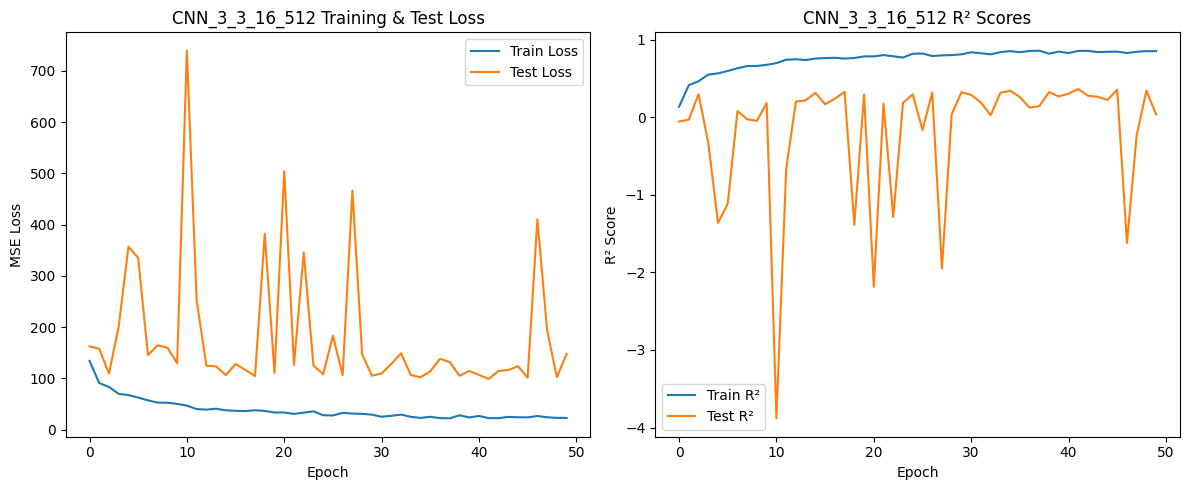

In [22]:
# session 1
results = train_cnn_model(model_class=model_20250901.CNN_3_3_16_512,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=50,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_3_3_16_512 Training Summary ===
Best Epoch: 26
Best Test Loss: 93.9568
Corresponding Test R²: 0.3994
Final Train Loss: 32.2568 ± 33.3238
Final Train R²: 0.7921 ± 0.2147
Final Test Loss: 105.4584 ± 14.1270
Final Test R²: 0.3097 ± 0.0921


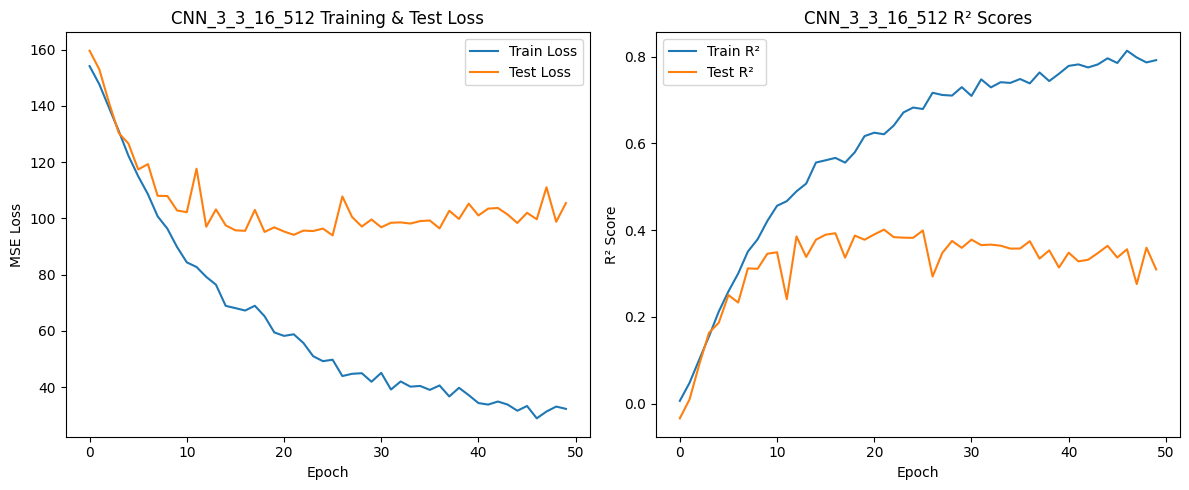

In [23]:
# session 2 
results = train_cnn_model(model_class=model_20250901.CNN_3_3_16_512,
                        lr=0.0001,
                        weight_decay=0.0,
                        num_epochs=50,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_2_2_16_512 Training Summary ===
Best Epoch: 40
Best Test Loss: 95.5187
Corresponding Test R²: 0.3861
Final Train Loss: 56.4512 ± 20.9286
Final Train R²: 0.6362 ± 0.1349
Final Test Loss: 1109.1006 ± 190.3483
Final Test R²: -6.1372 ± 1.2236


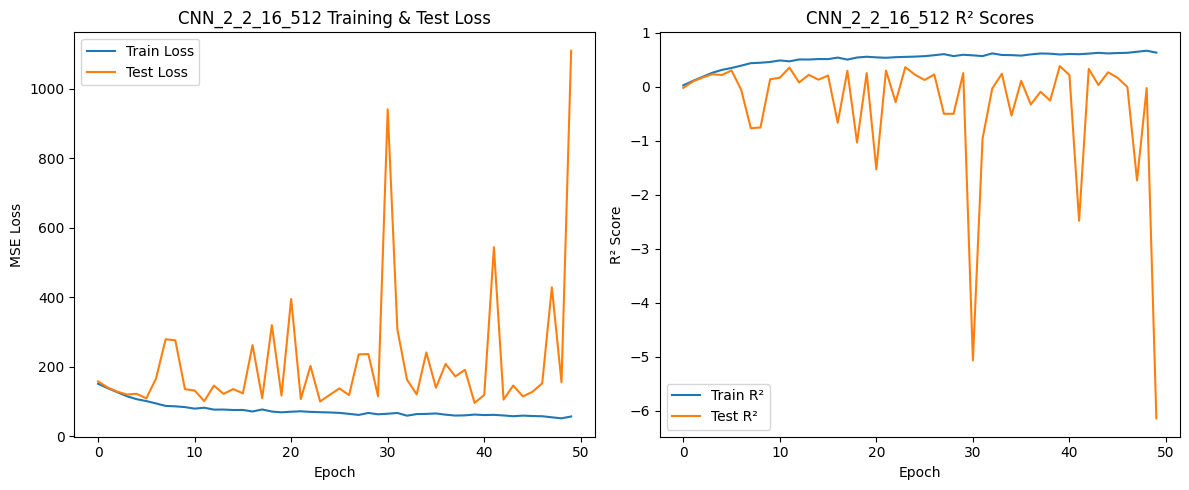

In [24]:
# session 3 
results = train_cnn_model(model_class=model_20250901.CNN_2_2_16_512,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=50,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_2_2_16_512 Training Summary ===
Best Epoch: 48
Best Test Loss: 101.7415
Corresponding Test R²: 0.3548
Final Train Loss: 94.4074 ± 18.4263
Final Train R²: 0.3916 ± 0.1187
Final Test Loss: 102.4681 ± 15.6855
Final Test R²: 0.3502 ± 0.1054


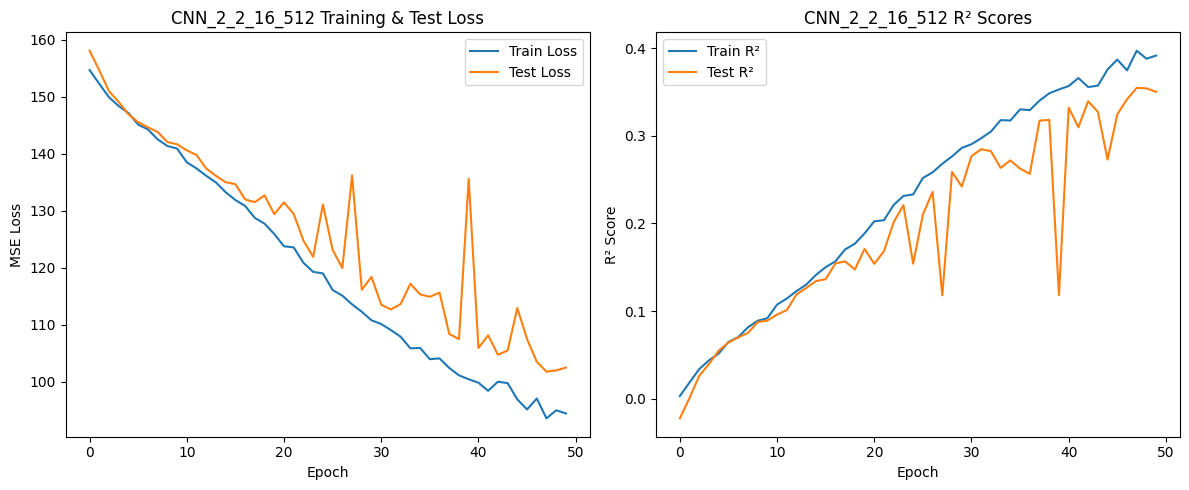

In [25]:
# session 4
results = train_cnn_model(model_class=model_20250901.CNN_2_2_16_512,
                        lr=0.0001,
                        weight_decay=0.0,
                        num_epochs=50,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_3_3_16_256 Training Summary ===
Best Epoch: 14
Best Test Loss: 95.1007
Corresponding Test R²: 0.3761
Final Train Loss: 29.5578 ± 23.9198
Final Train R²: 0.8095 ± 0.1541
Final Test Loss: 581.7317 ± 130.5071
Final Test R²: -2.7396 ± 0.8363


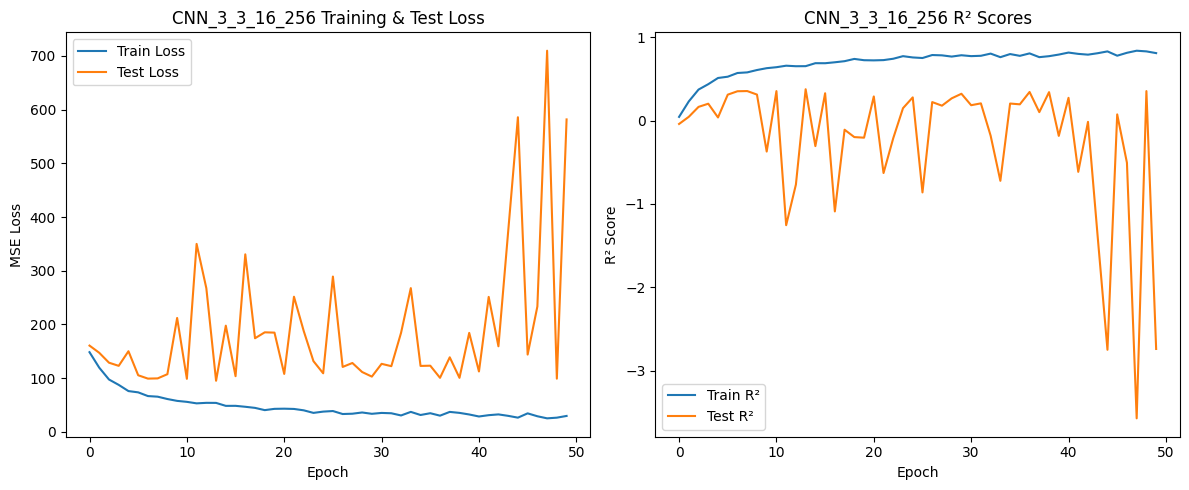

In [26]:
# session 5
results = train_cnn_model(model_class=model_20250901.CNN_3_3_16_256,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=50,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_3_3_16_256 Training Summary ===
Best Epoch: 35
Best Test Loss: 101.1665
Corresponding Test R²: 0.3461
Final Train Loss: 36.3771 ± 37.8876
Final Train R²: 0.7656 ± 0.2441
Final Test Loss: 109.0722 ± 16.4269
Final Test R²: 0.2900 ± 0.1062


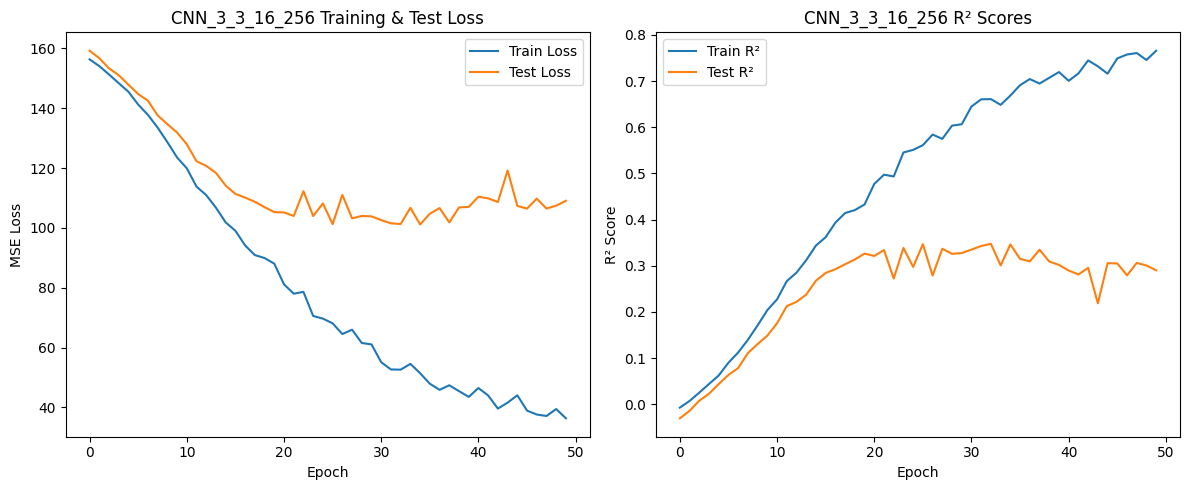

In [27]:
# session 6

results = train_cnn_model(model_class=model_20250901.CNN_3_3_16_256,
                        lr=0.0001,
                        weight_decay=0.0,
                        num_epochs=50,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_2_2_16_256 Training Summary ===
Best Epoch: 13
Best Test Loss: 94.9608
Corresponding Test R²: 0.3938
Final Train Loss: 59.5751 ± 23.4771
Final Train R²: 0.6161 ± 0.1513
Final Test Loss: 144.0373 ± 440.2956
Final Test R²: 0.0793 ± 2.8449


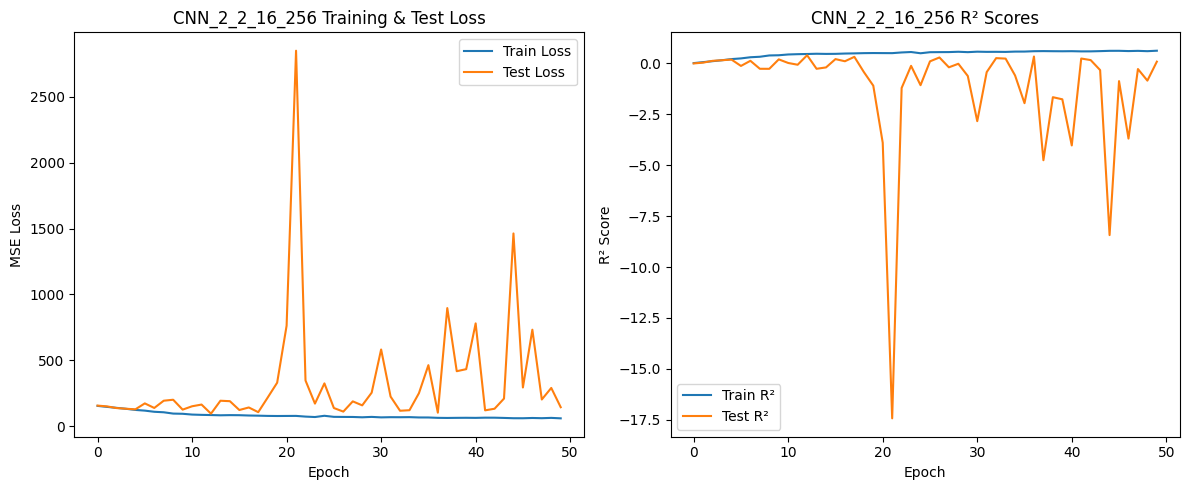

In [28]:
# session 7
results = train_cnn_model(model_class=model_20250901.CNN_2_2_16_256,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=50,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_2_2_16_256 Training Summary ===
Best Epoch: 45
Best Test Loss: 121.8798
Corresponding Test R²: 0.2211
Final Train Loss: 109.1652 ± 13.3538
Final Train R²: 0.2965 ± 0.0861
Final Test Loss: 140.8561 ± 9.5160
Final Test R²: 0.0862 ± 0.0637


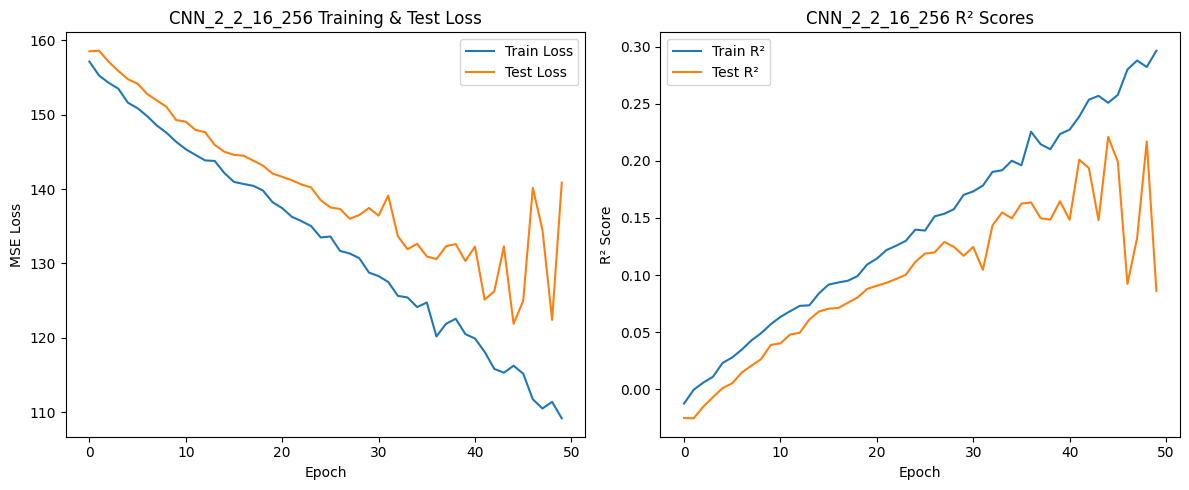

In [29]:
# session 8
results = train_cnn_model(model_class=model_20250901.CNN_2_2_16_256,
                        lr=0.0001,
                        weight_decay=0.0,
                        num_epochs=50,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_3_3_8_512 Training Summary ===
Best Epoch: 13
Best Test Loss: 100.1243
Corresponding Test R²: 0.3537
Final Train Loss: 23.6487 ± 21.0461
Final Train R²: 0.8476 ± 0.1356
Final Test Loss: 125.4214 ± 205.6324
Final Test R²: 0.1872 ± 1.3510


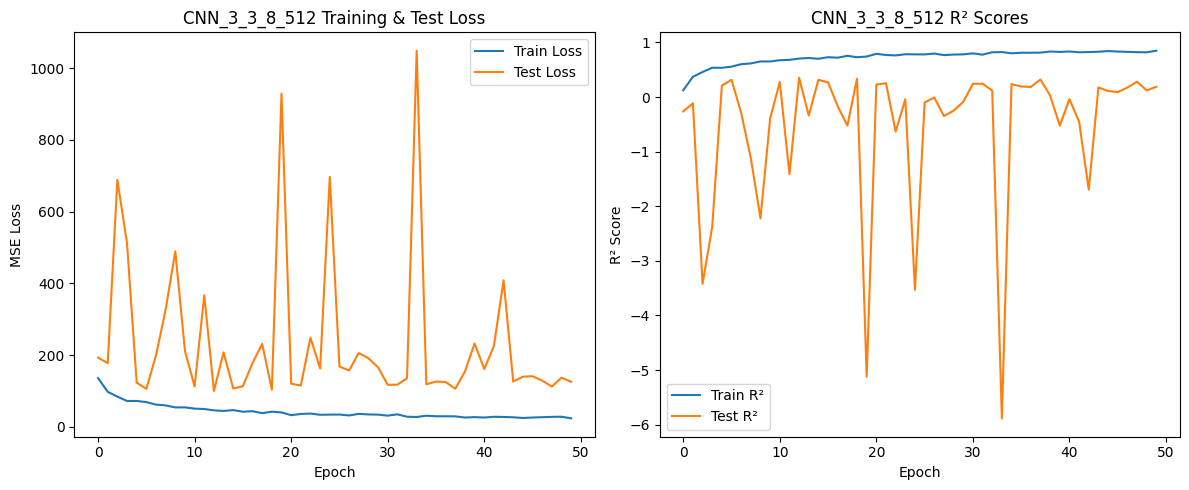

In [30]:
# session 9

results = train_cnn_model(model_class=model_20250901.CNN_3_3_8_512,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=50,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_3_3_8_512 Training Summary ===
Best Epoch: 26
Best Test Loss: 86.4577
Corresponding Test R²: 0.4462
Final Train Loss: 44.5579 ± 31.1353
Final Train R²: 0.7129 ± 0.2006
Final Test Loss: 90.9491 ± 18.2979
Final Test R²: 0.4101 ± 0.1194


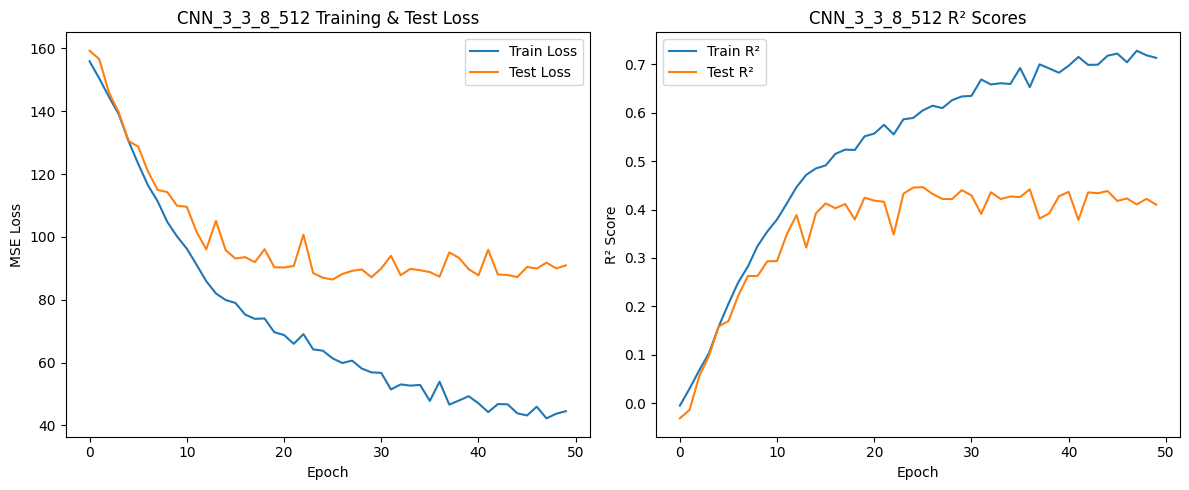

In [31]:
# session 10

results = train_cnn_model(model_class=model_20250901.CNN_3_3_8_512,
                        lr=0.0001,
                        weight_decay=0.0,
                        num_epochs=50,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_2_2_8_512 Training Summary ===
Best Epoch: 50
Best Test Loss: 90.6059
Corresponding Test R²: 0.4100
Final Train Loss: 57.8830 ± 20.0614
Final Train R²: 0.6270 ± 0.1293
Final Test Loss: 90.6059 ± 113.6353
Final Test R²: 0.4100 ± 0.7568


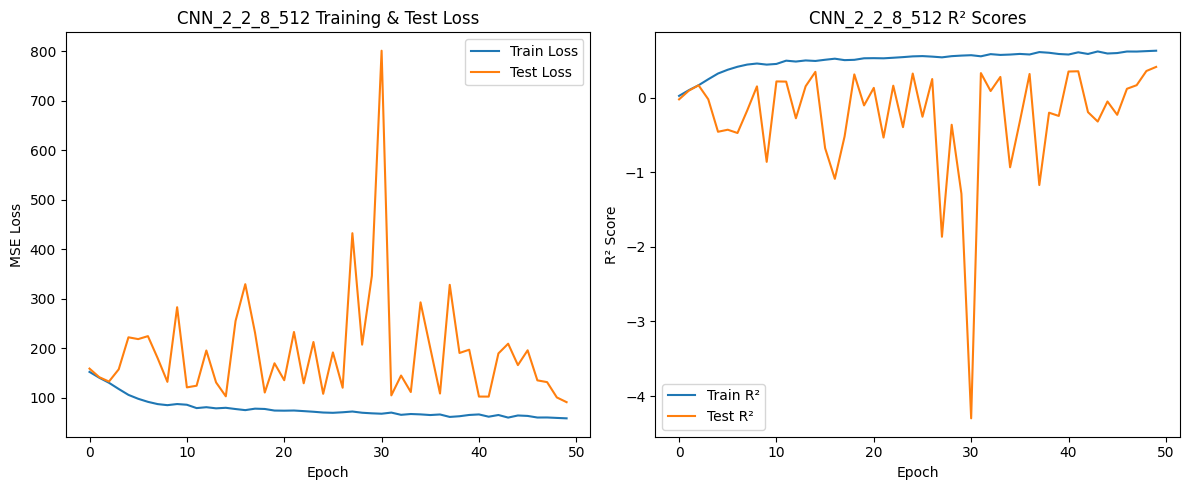

In [32]:
# session 11
results = train_cnn_model(model_class=model_20250901.CNN_2_2_8_512,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=50,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_2_2_8_512 Training Summary ===
Best Epoch: 50
Best Test Loss: 109.0650
Corresponding Test R²: 0.3111
Final Train Loss: 96.9685 ± 17.4690
Final Train R²: 0.3751 ± 0.1126
Final Test Loss: 109.0650 ± 12.7664
Final Test R²: 0.3111 ± 0.0855


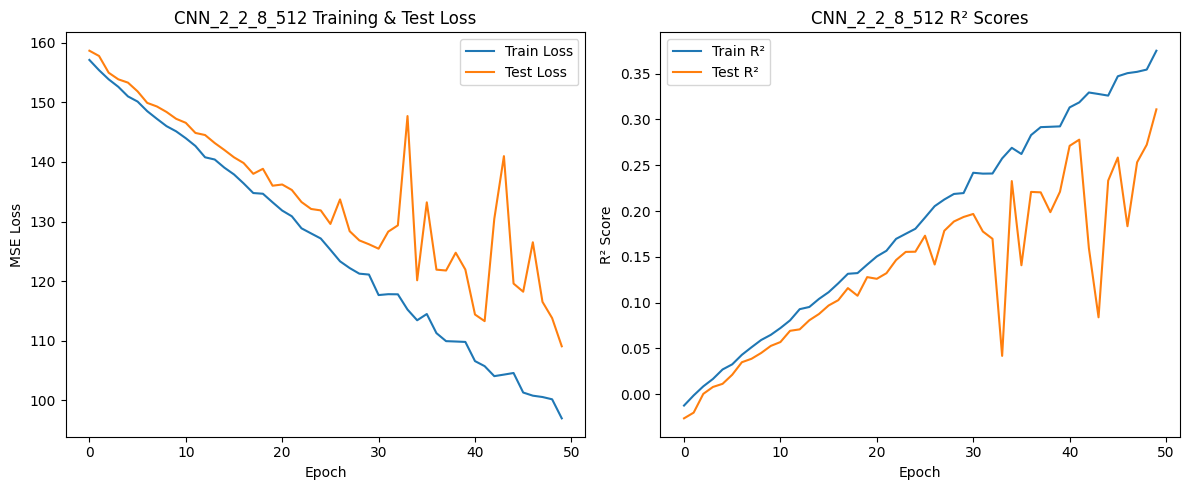

In [33]:
# session 12
results = train_cnn_model(model_class=model_20250901.CNN_2_2_8_512,
                        lr=0.0001,
                        weight_decay=0.0,
                        num_epochs=50,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_3_3_8_256 Training Summary ===
Best Epoch: 25
Best Test Loss: 100.7685
Corresponding Test R²: 0.3485
Final Train Loss: 38.4781 ± 22.3884
Final Train R²: 0.7521 ± 0.1443
Final Test Loss: 140.8574 ± 92.9792
Final Test R²: 0.0843 ± 0.6002


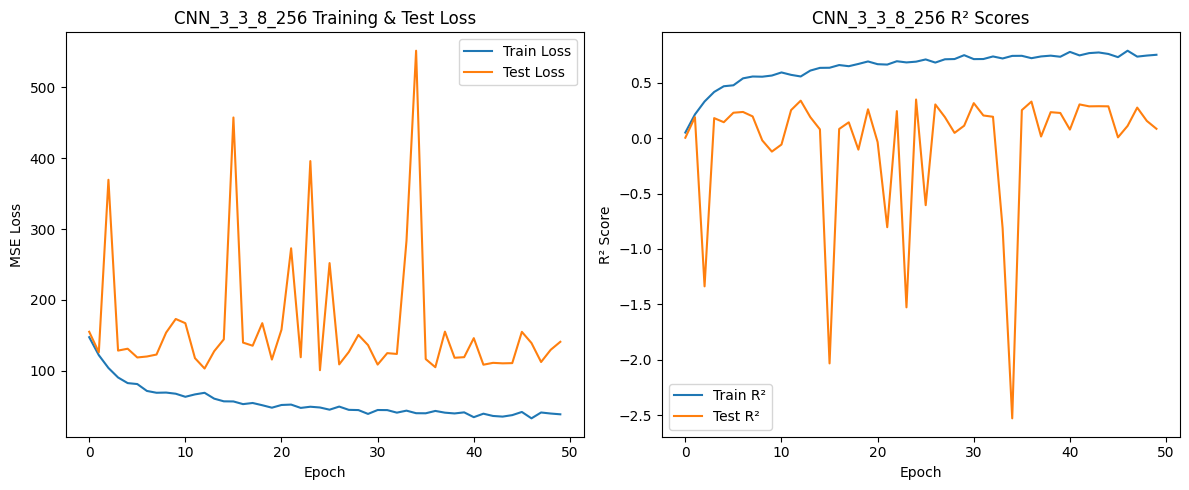

In [34]:
# session 13
results = train_cnn_model(model_class=model_20250901.CNN_3_3_8_256,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=50,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_3_3_8_256 Training Summary ===
Best Epoch: 44
Best Test Loss: 88.6323
Corresponding Test R²: 0.4325
Final Train Loss: 55.8120 ± 31.6027
Final Train R²: 0.6404 ± 0.2036
Final Test Loss: 91.4492 ± 21.4185
Final Test R²: 0.4086 ± 0.1403


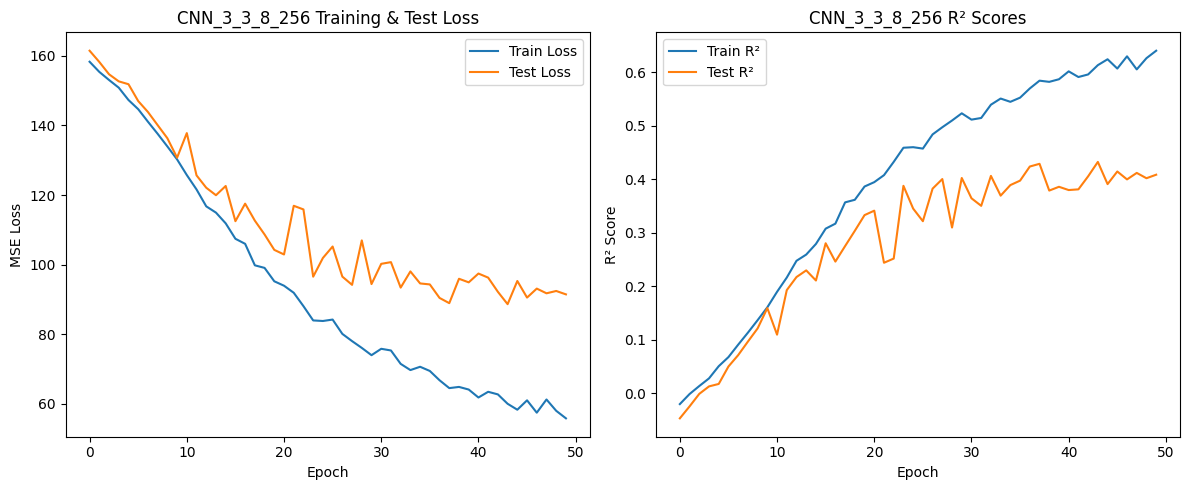

In [35]:
# session 14
results = train_cnn_model(model_class=model_20250901.CNN_3_3_8_256,
                        lr=0.0001,
                        weight_decay=0.0,
                        num_epochs=50,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_2_2_8_256 Training Summary ===
Best Epoch: 42
Best Test Loss: 91.4176
Corresponding Test R²: 0.4012
Final Train Loss: 67.1573 ± 19.7374
Final Train R²: 0.5672 ± 0.1272
Final Test Loss: 388.3500 ± 666.2601
Final Test R²: -1.4762 ± 4.3157


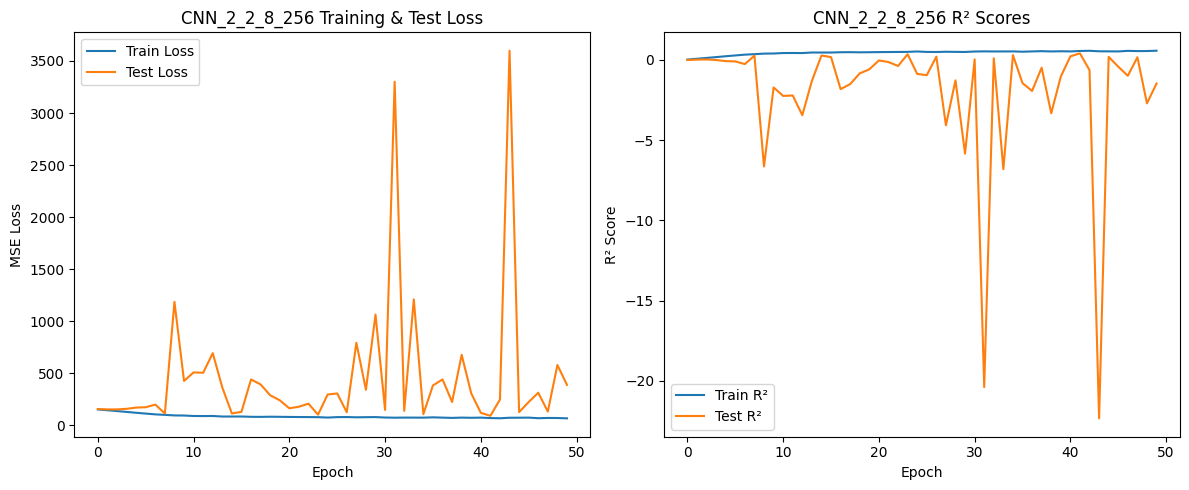

In [36]:
# session 15
results = train_cnn_model(model_class=model_20250901.CNN_2_2_8_256,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=50,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_2_2_8_256 Training Summary ===
Best Epoch: 50
Best Test Loss: 127.1003
Corresponding Test R²: 0.1863
Final Train Loss: 120.5986 ± 10.5463
Final Train R²: 0.2229 ± 0.0680
Final Test Loss: 127.1003 ± 8.9171
Final Test R²: 0.1863 ± 0.0601


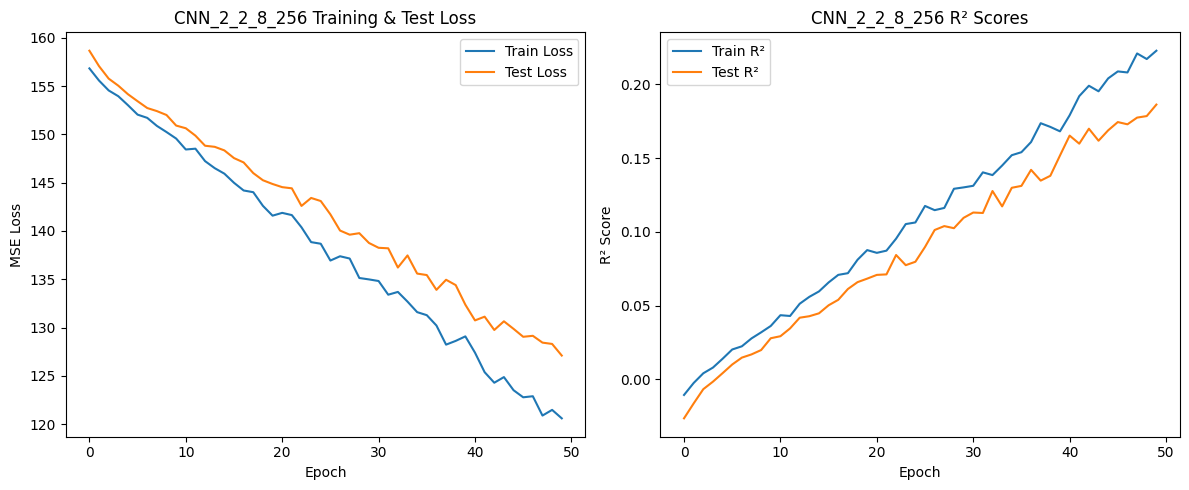

In [37]:
# session 16
results = train_cnn_model(model_class=model_20250901.CNN_2_2_8_256,
                        lr=0.0001,
                        weight_decay=0.0,
                        num_epochs=50,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_3_3_8_128 Training Summary ===
Best Epoch: 22
Best Test Loss: 98.9479
Corresponding Test R²: 0.3616
Final Train Loss: 44.1311 ± 22.9373
Final Train R²: 0.7156 ± 0.1478
Final Test Loss: 216.3957 ± 79.6623
Final Test R²: -0.4328 ± 0.5222


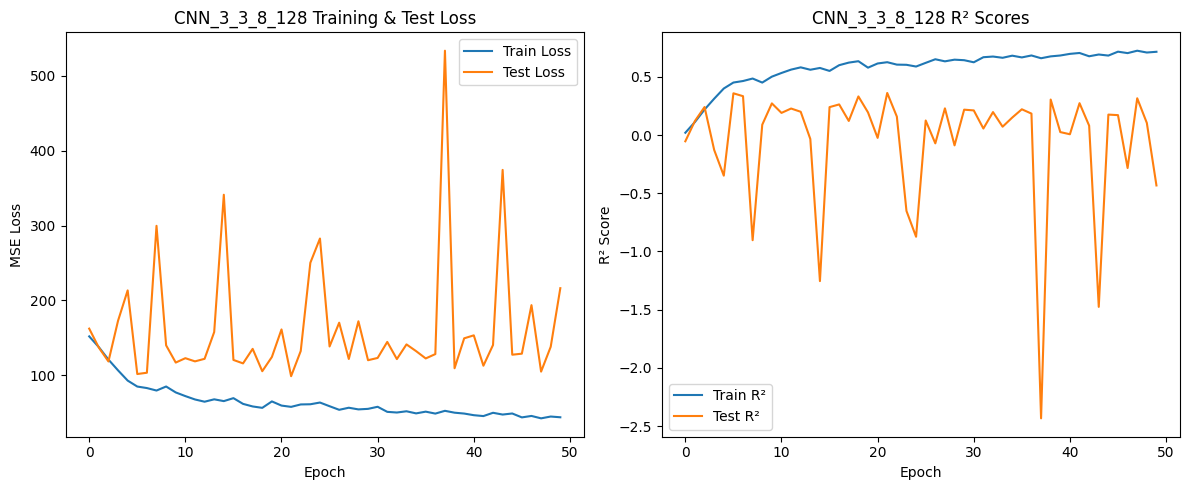

In [38]:
# session 17
results = train_cnn_model(model_class=model_20250901.CNN_3_3_8_128,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=50,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_3_3_8_128 Training Summary ===
Best Epoch: 46
Best Test Loss: 100.1599
Corresponding Test R²: 0.3607
Final Train Loss: 74.7819 ± 26.5885
Final Train R²: 0.5181 ± 0.1713
Final Test Loss: 105.7557 ± 19.0929
Final Test R²: 0.3268 ± 0.1276


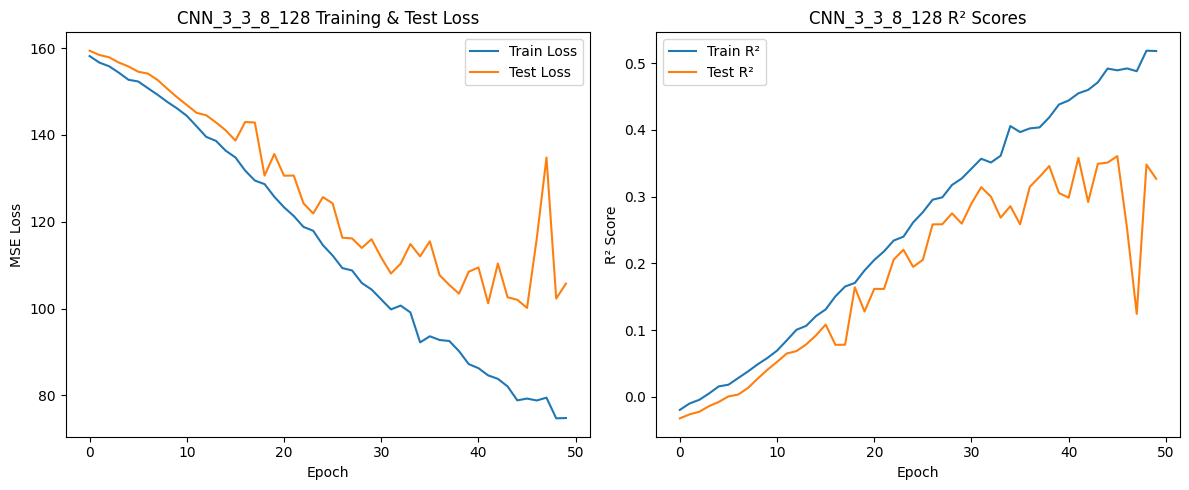

In [39]:
# session 18
results = train_cnn_model(model_class=model_20250901.CNN_3_3_8_128,
                        lr=0.0001,
                        weight_decay=0.0,
                        num_epochs=50,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_2_2_8_128 Training Summary ===
Best Epoch: 29
Best Test Loss: 110.3033
Corresponding Test R²: 0.2947
Final Train Loss: 76.5433 ± 21.8397
Final Train R²: 0.5068 ± 0.1407
Final Test Loss: 154.6477 ± 779.6281
Final Test R²: -0.0066 ± 5.0669


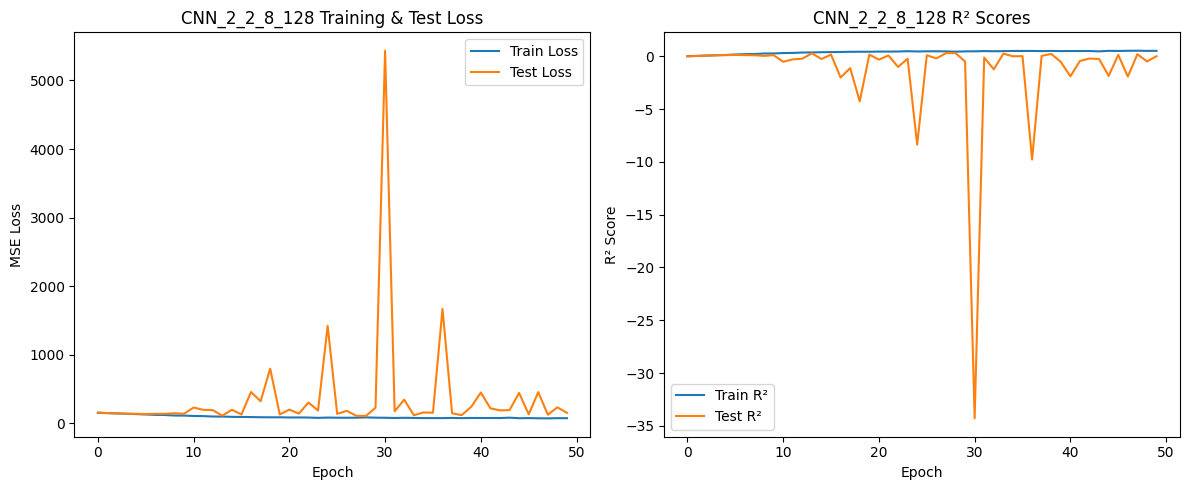

In [40]:
# session 19
results = train_cnn_model(model_class=model_20250901.CNN_2_2_8_128,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=50,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_2_2_8_128 Training Summary ===
Best Epoch: 50
Best Test Loss: 136.9995
Corresponding Test R²: 0.1198
Final Train Loss: 133.7702 ± 6.3891
Final Train R²: 0.1380 ± 0.0412
Final Test Loss: 136.9995 ± 5.9250
Final Test R²: 0.1198 ± 0.0404


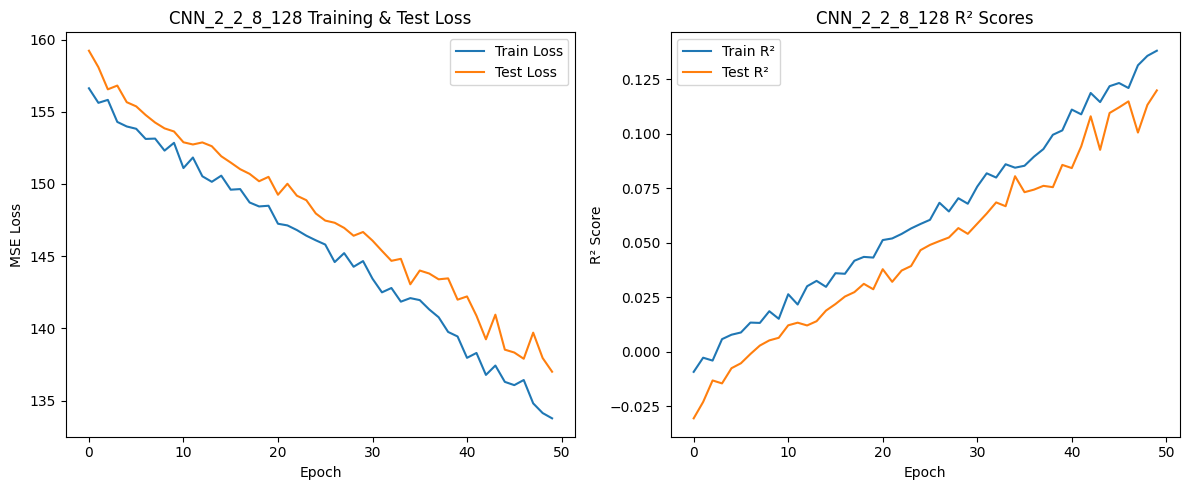

In [41]:
# session 20
results = train_cnn_model(model_class=model_20250901.CNN_2_2_8_128,
                        lr=0.0001,
                        weight_decay=0.0,
                        num_epochs=50,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_3_3_16_128 Training Summary ===
Best Epoch: 10
Best Test Loss: 100.1588
Corresponding Test R²: 0.3519
Final Train Loss: 32.5314 ± 26.5586
Final Train R²: 0.7904 ± 0.1711
Final Test Loss: 109.9738 ± 105.2011
Final Test R²: 0.2910 ± 0.6768


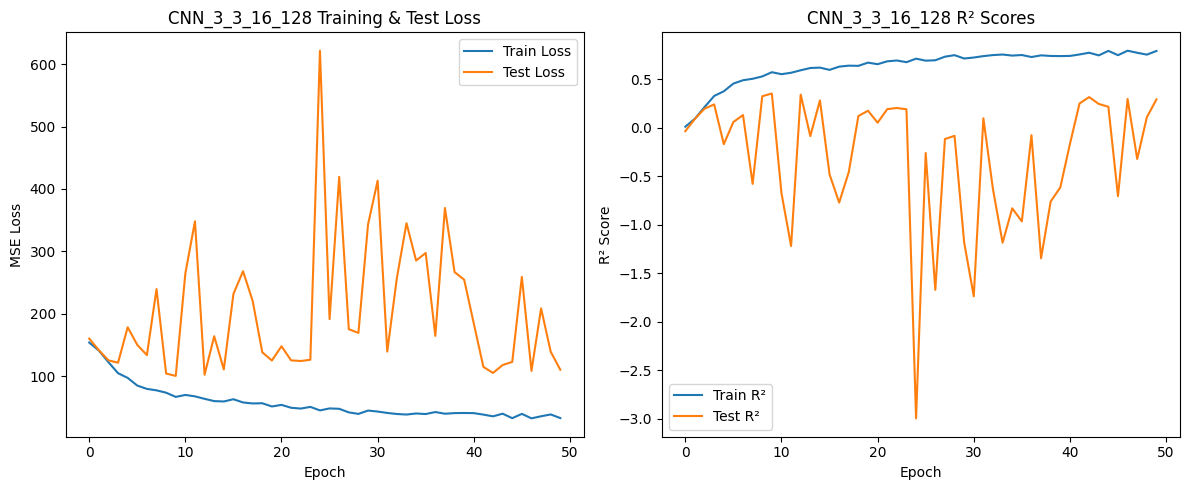

In [42]:
# session 21
results = train_cnn_model(model_class=model_20250901.CNN_3_3_16_128,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=50,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_3_3_16_128 Training Summary ===
Best Epoch: 48
Best Test Loss: 102.2368
Corresponding Test R²: 0.3340
Final Train Loss: 47.2561 ± 34.1635
Final Train R²: 0.6955 ± 0.2201
Final Test Loss: 106.4607 ± 16.7677
Final Test R²: 0.3074 ± 0.1084


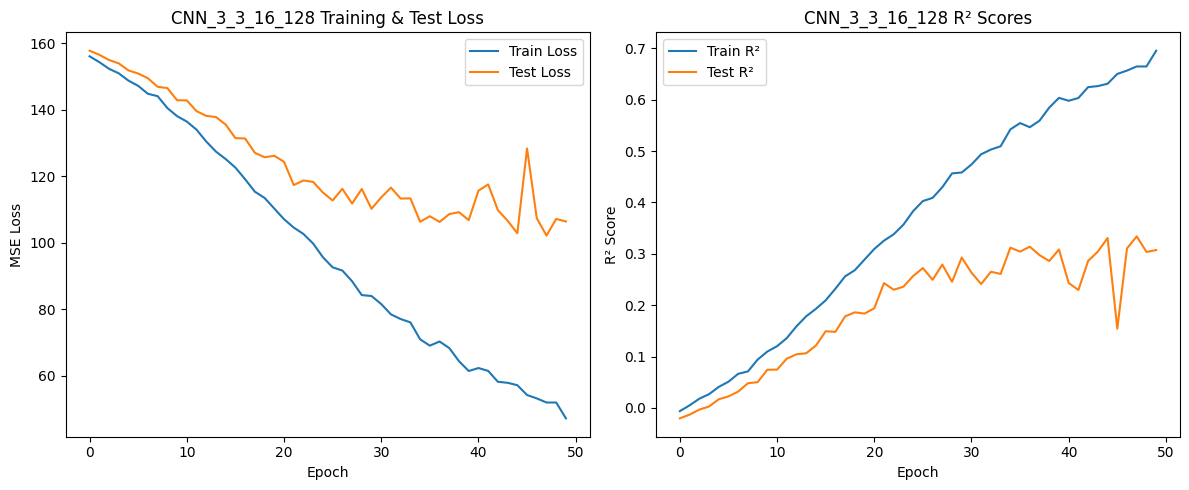

In [43]:
# session 22
results = train_cnn_model(model_class=model_20250901.CNN_3_3_16_128,
                        lr=0.0001,
                        weight_decay=0.0,
                        num_epochs=50,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_2_2_16_128 Training Summary ===
Best Epoch: 47
Best Test Loss: 97.8638
Corresponding Test R²: 0.3664
Final Train Loss: 67.6663 ± 23.3056
Final Train R²: 0.5640 ± 0.1502
Final Test Loss: 109.4896 ± 117.0867
Final Test R²: 0.3067 ± 0.7746


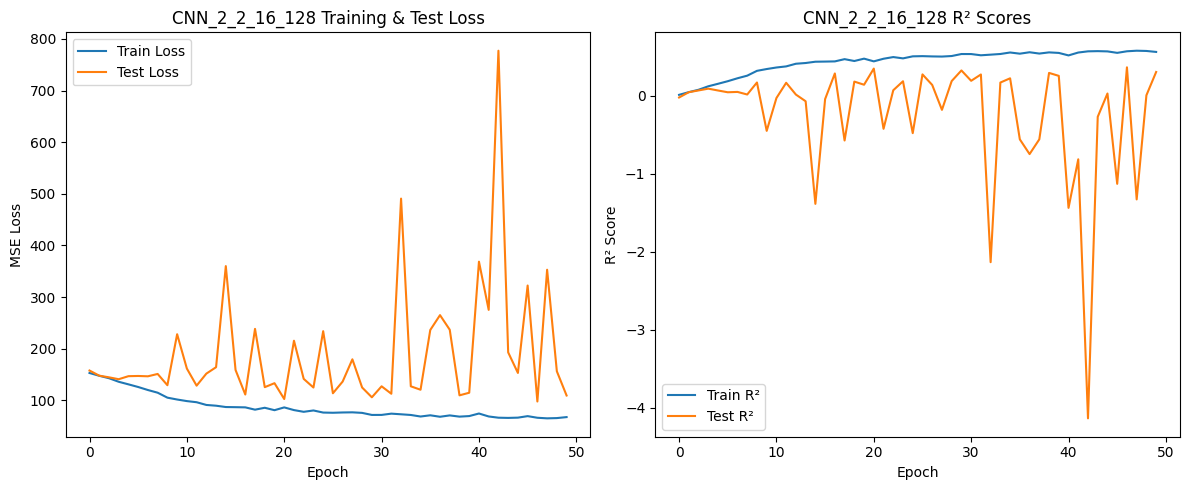

In [44]:
# session 23
results = train_cnn_model(model_class=model_20250901.CNN_2_2_16_128,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=50,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_2_2_16_128 Training Summary ===
Best Epoch: 47
Best Test Loss: 130.2217
Corresponding Test R²: 0.1663
Final Train Loss: 124.9790 ± 8.6370
Final Train R²: 0.1946 ± 0.0557
Final Test Loss: 130.3008 ± 7.5306
Final Test R²: 0.1642 ± 0.0512


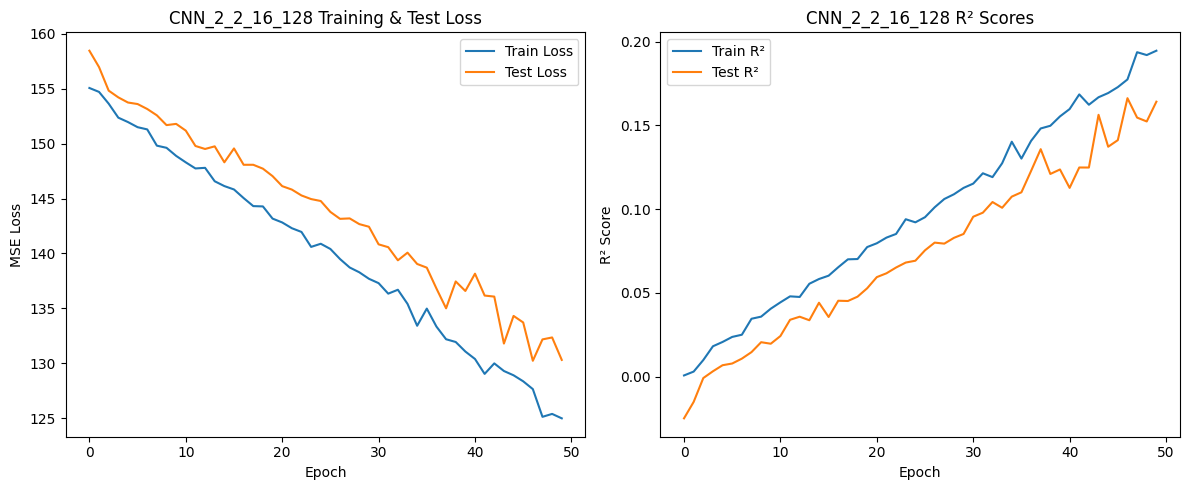

In [45]:
# session 24
results = train_cnn_model(model_class=model_20250901.CNN_2_2_16_128,
                        lr=0.0001,
                        weight_decay=0.0,
                        num_epochs=50,
                        train_loader=train_loader,
                        test_loader=test_loader)